In [724]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from pyproj import Proj
from pandas.io.json import json_normalize

In [1018]:
file = 'Census_by_Community_2019.csv'
raw_dat = pd.read_csv(file)

### Data Wrangling 

#### After reviewing the City of Calgary data, I noticed that there are missing values for some of the dwelling types. So, the data related to dwelling structure was also not included in the final data so it doesn't affect the clustering later. We are more interested in demographics data than the structure type, etc. 

In [1019]:
yyc_raw_df = raw_dat.drop(columns = ['CLASS_CODE','COMM_CODE','SECTOR','FOIP_IND','CNSS_YR','ELECT_CNT','EMPLYD_CNT','DOG_CNT','CAT_CNT','PUB_SCH',
                                 'SEP_SCH','PUBSEP_SCH','OTHER_SCH','UNKNWN_SCH','DUPLEX','MULTI_PLEX','APARTMENT','TOWN_HOUSE','MANUF_HOME','CONV_STRUC',
                                 'COMUNL_HSE','RES_COMM','OTHER_RES','NURSING_HM','OTHER_INST','HOTEL_CNT','OTHER_MISC','APT_NO_RES','APT_OCCPD','APT_OWNED',
                                 'APT_PERSON','APT_VACANT','APT_UC','APT_NA','CNV_NO_RES','CNV_OCCPD','CNV_OWNED','CNV_PERSON','CNV_VACANT','CNV_UC','CNV_NA',
                                 'DUP_NO_RES','DUP_OCCPD','DUP_OWNED','DUP_PERSON','DUP_VACANT','DUP_UC','DUP_NA','MFH_NO_RES','MFH_OCCPD','MFH_OWNED',
                                 'MFH_PERSON','MFH_VACANT','MFH_UC','MFH_NA','MUL_NO_RES','MUL_OCCPD','MUL_OWNED','MUL_PERSON','MUL_VACANT','MUL_UC',
                                 'MUL_NA','OTH_NO_RES','OTH_OCCPD','OTH_OWNED','OTH_PERSON','OTH_VACANT','OTH_UC','OTH_NA','TWN_NO_RES','TWN_OCCPD','TWN_OWNED',
                                 'TWN_PERSON','TWN_VACANT','TWN_UC','TWN_NA','SF_NO_RES','SF_OCCPD','SF_OWNED','SF_PERSON','SF_VACANT','SF_UC','SF_NA','OTH_STRTY',
                                 'DWELSZ_1','DWELSZ_2','DWELSZ_3','DWELSZ_4_5','DWELSZ_6','MALE_CNT','FEMALE_CNT','OTHER_CNT','OTHER_0_4','OTHER_5_14','OTHER_15_19',
                                 'OTHER_20_24','OTHER_25_34','MF_0_4','MF_5_14','MF_15_19','MF_20_24','MF_25_34','MF_35_44','MF_45_54','MF_55_64','MF_65_74','MF_75',
                                 'OTHER_35_44','OTHER_45_54','OTHER_55_64','OTHER_65_74','OTHER_75'])

In [1020]:
yyc_raw_df.head() 

CLASS           NAME         SRG COMM_STRUCTURE  RES_CNT  DWELL_CNT  \
0  Residential         LEGACY  DEVELOPING   BUILDING OUT     6420       2766   
1  Residential  HIGHLAND PARK   BUILT-OUT          1950s     3838       2277   
2  Residential    CORNERSTONE  DEVELOPING          2000s     2648       1285   
3  Residential     MONTGOMERY   BUILT-OUT          1950s     4515       2013   
4  Residential         TEMPLE   BUILT-OUT    1960s/1970s    10977       3733   

   PRSCH_CHLD  OWNSHP_CNT  SING_FAMLY  MALE_0_4  ...  FEM_5_14  FEM_15_19  \
0         850        1826        1081       330  ...       375        153   
1         325         645         823       142  ...       155         39   
2         199         708         595       136  ...       131         65   
3         328        1027         987       150  ...       186         77   
4         908        2460        2304       353  ...       767        332   

   FEM_20_24  FEM_25_34  FEM_35_44  FEM_45_54  FEM_55_64  FEM_65_74  FEM_75  \
0        206        810        600        355        250        141      37   
1         98        413        342        221        216        112     110   
2         51        332        254        124        123         64       0   
3        163        506        398        267        278        144     135   
4        333        799        857        620        702        468     159   

                                        multipolygon  
0  MULTIPOLYGON (((-114.021996041091 50.863078904...  
1  MULTIPOLYGON (((-114.0691626854784 51.09565033...  
2  MULTIPOLYGON (((-113.91839732026011 51.1760690...  
3  MULTIPOLYGON (((-114.16457918083577 51.0814533...  
4  MULTIPOLYGON (((-113.93512706147847 51.0960756...  

[5 rows x 30 columns]

#### Keeping only 'Residential' neighborhoods and Non 'EMPLOYMENT' (e.g. deleting downtown area which have low population but high number of eateries or services)

In [1022]:
yyc_raw_df = yyc_raw_df.loc[(yyc_raw_df['CLASS'] == 'Residential')  & (yyc_raw_df['COMM_STRUCTURE'] != 'EMPLOYMENT')].reset_index()

In [1024]:
yyc_raw_df.shape

(211, 31)

In [1025]:
yyc_raw_df.dtypes

index              int64
CLASS             object
NAME              object
SRG               object
COMM_STRUCTURE    object
RES_CNT            int64
DWELL_CNT          int64
PRSCH_CHLD         int64
OWNSHP_CNT         int64
SING_FAMLY         int64
MALE_0_4           int64
MALE_5_14          int64
MALE_15_19         int64
MALE_20_24         int64
MALE_25_34         int64
MALE_35_44         int64
MALE_45_54         int64
MALE_55_64         int64
MALE_65_74         int64
MALE_75            int64
FEM_0_4            int64
FEM_5_14           int64
FEM_15_19          int64
FEM_20_24          int64
FEM_25_34          int64
FEM_35_44          int64
FEM_45_54          int64
FEM_55_64          int64
FEM_65_74          int64
FEM_75             int64
multipolygon      object
dtype: object

#### Combining with property assessment. Original property assessment csv was downloaded in a separate notebook and only the final csv is imported here. Original csv file contained more than 7 million property assessments with unique address in Calgary. 

In [1026]:
file ='Property_Assessment_Sum.csv'
assessment_df = pd.read_csv(file, index_col = None)

In [1027]:
assessment_by_community = assessment_df.groupby('COMM_NAME').mean().reset_index()
assessment_by_community.rename(columns = {'COMM_NAME':'NAME', } , inplace = True)
assessment_by_community.head()

NAME  ASSESSED_VALUE
0                     ABBEYDALE   254197.359104
1                        ACADIA   304135.298271
2  ALBERT PARK/RADISSON HEIGHTS   420062.846832
3                   ALPINE PARK   700500.000000
4                      ALTADORE   582748.227993

In [1028]:
yyc_df = pd.merge(yyc_raw_df, assessment_by_community, on="NAME")
yyc_df.head()

index        CLASS           NAME         SRG COMM_STRUCTURE  RES_CNT  \
0      0  Residential         LEGACY  DEVELOPING   BUILDING OUT     6420   
1      1  Residential  HIGHLAND PARK   BUILT-OUT          1950s     3838   
2      2  Residential    CORNERSTONE  DEVELOPING          2000s     2648   
3      3  Residential     MONTGOMERY   BUILT-OUT          1950s     4515   
4      4  Residential         TEMPLE   BUILT-OUT    1960s/1970s    10977   

   DWELL_CNT  PRSCH_CHLD  OWNSHP_CNT  SING_FAMLY  ...  FEM_15_19  FEM_20_24  \
0       2766         850        1826        1081  ...        153        206   
1       2277         325         645         823  ...         39         98   
2       1285         199         708         595  ...         65         51   
3       2013         328        1027         987  ...         77        163   
4       3733         908        2460        2304  ...        332        333   

   FEM_25_34  FEM_35_44  FEM_45_54  FEM_55_64  FEM_65_74  FEM_75  \
0        810        600        355        250        141      37   
1        413        342        221        216        112     110   
2        332        254        124        123         64       0   
3        506        398        267        278        144     135   
4        799        857        620        702        468     159   

                                        multipolygon  ASSESSED_VALUE  
0  MULTIPOLYGON (((-114.021996041091 50.863078904...    1.370800e+06  
1  MULTIPOLYGON (((-114.0691626854784 51.09565033...    4.114281e+05  
2  MULTIPOLYGON (((-113.91839732026011 51.1760690...    2.933657e+06  
3  MULTIPOLYGON (((-114.16457918083577 51.0814533...    4.249123e+05  
4  MULTIPOLYGON (((-113.93512706147847 51.0960756...    2.753478e+05  

[5 rows x 32 columns]

#### Reading community coordiantes and combining it with previous dataframe 

In [1029]:
file = 'Community_Points.csv'
raw_coordinates_dat = pd.read_csv(file)

In [1030]:
raw_coordinates_dat.head()

CLASS  CLASS_CODE COMM_CODE      NAME     SECTOR         SRG  \
0        Residential           1       WAL    WALDEN      SOUTH  DEVELOPING   
1  Residual Sub Area           4       12C       12C  SOUTHEAST         NaN   
2        Residential           1       HSN  HASKAYNE  NORTHWEST  DEVELOPING   
3  Residual Sub Area           4       05G       05G  NORTHEAST         NaN   
4  Residual Sub Area           4       13M       13M      SOUTH         NaN   

  COMM_STRUCTURE   longitude   latitude                              location  
0   BUILDING OUT -114.032588  50.870404  (50.870404086764, -114.032588132238)  
1          OTHER -113.903433  50.925093  (50.925093242931, -113.903433176841)  
2   BUILDING OUT -114.286632  51.116943  (51.116943479851, -114.286631687736)  
3          OTHER -113.916500  51.136193  (51.136192848558, -113.916500322111)  
4    UNDEVELOPED -114.042754  50.856239   (50.85623929309, -114.042753841451)

In [1031]:
yyc_coordinates_df = raw_coordinates_dat[['CLASS','NAME','COMM_STRUCTURE','longitude', 'latitude']]
yyc_coordinates_df = yyc_coordinates_df.loc[(yyc_coordinates_df['CLASS'] == 'Residential')  & (yyc_coordinates_df['COMM_STRUCTURE'] != 'EMPLOYMENT')]

In [1032]:
yyc_coordinates_df = yyc_coordinates_df[['NAME','longitude','latitude']]
yyc_coordinates_df.rename(columns={"longitude": "LONGITUDE", "latitude": "LATITUDE"}, inplace = True)
yyc_coordinates_df.head()

NAME   LONGITUDE   LATITUDE
0     WALDEN -114.032588  50.870404
2   HASKAYNE -114.286632  51.116943
5    BELMONT -114.055280  50.868746
6      SETON -113.947448  50.873700
8  HOMESTEAD -113.916499  51.121630

#### Merging two data frames together 

In [1033]:
yyc_dat = pd.merge(yyc_df, yyc_coordinates_df, on="NAME")

In [1034]:
yyc_dat.shape

(210, 34)

#### Before any modelling, I converted most of the counts to ratio to normalize all columns

In [1035]:
yyc_dat['OWNSHIP_RATIO'] = yyc_dat['OWNSHP_CNT']/yyc_dat['DWELL_CNT']
yyc_dat['SING_FAMILY_RATIO'] = yyc_dat['SING_FAMLY']/yyc_dat['DWELL_CNT']
yyc_dat['PRSCH_CHLD_RATIO'] = yyc_dat['PRSCH_CHLD']/yyc_dat['RES_CNT']

In [1036]:
yyc_dat['TOTAL_MALE'] = yyc_dat.iloc[:, 10:20].sum(axis=1)
yyc_dat['TOTAL_FEM'] = yyc_dat.iloc[:,20:30].sum(axis=1)

In [1037]:
for n in range(10,20): 
    yyc_dat.iloc[:,n] = yyc_dat.iloc[:,n]/yyc_dat['TOTAL_MALE']
for n in range(20,30): 
    yyc_dat.iloc[:,n] = yyc_dat.iloc[:,n]/yyc_dat['TOTAL_FEM']

In [1038]:
yyc_dat['ASSESSED_VALUE'] = yyc_dat['ASSESSED_VALUE']/1000000
yyc_dat.rename({'ASSESSED_VALUE':'ASSESSED_VALUE_MILLION'}, inplace = True)
yyc_dat.head()

index        CLASS           NAME         SRG COMM_STRUCTURE  RES_CNT  \
0      0  Residential         LEGACY  DEVELOPING   BUILDING OUT     6420   
1      1  Residential  HIGHLAND PARK   BUILT-OUT          1950s     3838   
2      2  Residential    CORNERSTONE  DEVELOPING          2000s     2648   
3      3  Residential     MONTGOMERY   BUILT-OUT          1950s     4515   
4      4  Residential         TEMPLE   BUILT-OUT    1960s/1970s    10977   

   DWELL_CNT  PRSCH_CHLD  OWNSHP_CNT  SING_FAMLY  ...    FEM_75  \
0       2766         850        1826        1081  ...  0.011270   
1       2277         325         645         823  ...  0.059588   
2       1285         199         708         595  ...  0.000000   
3       2013         328        1027         987  ...  0.058926   
4       3733         908        2460        2304  ...  0.029681   

                                        multipolygon  ASSESSED_VALUE  \
0  MULTIPOLYGON (((-114.021996041091 50.863078904...        1.370800   
1  MULTIPOLYGON (((-114.0691626854784 51.09565033...        0.411428   
2  MULTIPOLYGON (((-113.91839732026011 51.1760690...        2.933657   
3  MULTIPOLYGON (((-114.16457918083577 51.0814533...        0.424912   
4  MULTIPOLYGON (((-113.93512706147847 51.0960756...        0.275348   

    LONGITUDE   LATITUDE  OWNSHIP_RATIO  SING_FAMILY_RATIO  PRSCH_CHLD_RATIO  \
0 -114.005999  50.857617       0.660159           0.390817          0.132399   
1 -114.062067  51.088023       0.283267           0.361440          0.084680   
2 -113.930582  51.157369       0.550973           0.463035          0.075151   
3 -114.162261  51.071099       0.510184           0.490313          0.072647   
4 -113.946768  51.088795       0.658987           0.617198          0.082718   

   TOTAL_MALE  TOTAL_FEM  
0        3125       3283  
1        1986       1846  
2        1409       1225  
3        2216       2291  
4        5597       5357  

[5 rows x 39 columns]

#### multipolygon column was used to extract the longitude and latitude values to calculate the area of each community. It is important to convert the residents count to population density so communities with larger population don not affect the clustering.  

In [1039]:
multipoly_all = yyc_raw_df.multipolygon
multipoly_community = [multipoly[16:-5].split(',') for multipoly in multipoly_all]

In [1040]:
multipoly_dict = {}
for i in range(yyc_raw_df.shape[0]):
    poly =[]
    community_poly = [multipoly.split() for multipoly in multipoly_community[i]]
    for j in range(len(community_poly)):    
        coordinates = (float(community_poly[j][0]),float(community_poly[j][1]))
        poly.append(coordinates)
    multipoly_dict[yyc_raw_df.NAME[i]] = poly 

#### Calculating the area for each neighborhood to calculate the polpulation density for each community

In [1041]:
def area_of_polygon(x, y):
    """Calculates the area of an arbitrary polygon given its verticies"""
    area = 0.0
    for i in range(-1, len(x)-1):
        area += x[i] * (y[i+1] - y[i-1])
    return abs(area) / 2.0

In [1042]:
area = []
for item in multipoly_dict.keys():
    lon, lat = zip(*multipoly_dict[item])
    pa = Proj("+proj=aea +lat_1=37.0 +lat_2=41.0 +lat_0=39.0 +lon_0=-106.55")
    x, y = pa(lon, lat)
    # cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
    # from shapely.geometry import shape
    # shape(cop).area  # 268952044107.43506
    community_area = area_of_polygon(x, y)
    area.append([item,community_area])

area_df = pd.DataFrame(area)

In [1043]:
area_df.rename(columns = {0:'NAME',1:'AREA'}, inplace = True)
area_df.head()

NAME          AREA
0         LEGACY  6.082707e+06
1  HIGHLAND PARK  1.370246e+06
2    CORNERSTONE  7.686694e+06
3     MONTGOMERY  2.952081e+06
4         TEMPLE  2.625337e+06

In [1044]:
yyc_community_area = pd.merge(yyc_community_dat, area_df, on="NAME")
yyc_community_area.head()

NAME COMM_STRUCTURE  RES_CNT  MALE_0_4  MALE_5_14  MALE_15_19  \
0         LEGACY   BUILDING OUT     6420  0.105600   0.123840    0.054720   
1  HIGHLAND PARK          1950s     3838  0.071501   0.084089    0.026183   
2    CORNERSTONE          2000s     2648  0.096522   0.142654    0.044713   
3     MONTGOMERY          1950s     4515  0.067690   0.090253    0.041516   
4         TEMPLE    1960s/1970s    10977  0.063070   0.145256    0.063248   

   MALE_20_24  MALE_25_34  MALE_35_44  MALE_45_54  ...  ASSESSED_VALUE  \
0    0.067840    0.226560    0.193280    0.118080  ...        1.370800   
1    0.059919    0.183283    0.229607    0.132931  ...        0.411428   
2    0.052520    0.195174    0.240596    0.097232  ...        2.933657   
3    0.069495    0.224278    0.175090    0.118682  ...        0.424912   
4    0.065928    0.145971    0.155440    0.122030  ...        0.275348   

    LONGITUDE   LATITUDE  OWNSHIP_RATIO  SING_FAMILY_RATIO  PRSCH_CHLD_RATIO  \
0 -114.005999  50.857617       0.660159           0.390817          0.132399   
1 -114.062067  51.088023       0.283267           0.361440          0.084680   
2 -113.930582  51.157369       0.550973           0.463035          0.075151   
3 -114.162261  51.071099       0.510184           0.490313          0.072647   
4 -113.946768  51.088795       0.658987           0.617198          0.082718   

   TOTAL_MALE  TOTAL_FEM  RES_CNT_THOUSANDS_PER_SQ_KM          AREA  
0        3125       3283                     1.055451  6.082707e+06  
1        1986       1846                     2.800957  1.370246e+06  
2        1409       1225                     0.344491  7.686694e+06  
3        2216       2291                     1.529429  2.952081e+06  
4        5597       5357                     4.181178  2.625337e+06  

[5 rows x 33 columns]

In [1045]:
yyc_community_dat = yyc_dat[['NAME','COMM_STRUCTURE','RES_CNT','MALE_0_4','MALE_5_14','MALE_15_19','MALE_20_24','MALE_25_34','MALE_35_44','MALE_45_54',
                             'MALE_55_64','MALE_65_74','MALE_75','FEM_0_4','FEM_5_14','FEM_15_19','FEM_20_24','FEM_25_34','FEM_35_44','FEM_45_54','FEM_55_64',
                             'FEM_65_74','FEM_75','ASSESSED_VALUE','LONGITUDE','LATITUDE','OWNSHIP_RATIO','SING_FAMILY_RATIO','PRSCH_CHLD_RATIO','TOTAL_MALE',
                             'TOTAL_FEM']]

In [1046]:
yyc_community_dat['RES_CNT_THOUSANDS_PER_SQ_KM'] = yyc_community_area['RES_CNT']/yyc_community_area['AREA']*10e+02 #residents count per sq km

C:\Users\Siavash Fard\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1047]:
yyc_community_dat.head()

NAME COMM_STRUCTURE  RES_CNT  MALE_0_4  MALE_5_14  MALE_15_19  \
0         LEGACY   BUILDING OUT     6420  0.105600   0.123840    0.054720   
1  HIGHLAND PARK          1950s     3838  0.071501   0.084089    0.026183   
2    CORNERSTONE          2000s     2648  0.096522   0.142654    0.044713   
3     MONTGOMERY          1950s     4515  0.067690   0.090253    0.041516   
4         TEMPLE    1960s/1970s    10977  0.063070   0.145256    0.063248   

   MALE_20_24  MALE_25_34  MALE_35_44  MALE_45_54  ...    FEM_75  \
0    0.067840    0.226560    0.193280    0.118080  ...  0.011270   
1    0.059919    0.183283    0.229607    0.132931  ...  0.059588   
2    0.052520    0.195174    0.240596    0.097232  ...  0.000000   
3    0.069495    0.224278    0.175090    0.118682  ...  0.058926   
4    0.065928    0.145971    0.155440    0.122030  ...  0.029681   

   ASSESSED_VALUE   LONGITUDE   LATITUDE  OWNSHIP_RATIO  SING_FAMILY_RATIO  \
0        1.370800 -114.005999  50.857617       0.660159           0.390817   
1        0.411428 -114.062067  51.088023       0.283267           0.361440   
2        2.933657 -113.930582  51.157369       0.550973           0.463035   
3        0.424912 -114.162261  51.071099       0.510184           0.490313   
4        0.275348 -113.946768  51.088795       0.658987           0.617198   

   PRSCH_CHLD_RATIO  TOTAL_MALE  TOTAL_FEM  RES_CNT_THOUSANDS_PER_SQ_KM  
0          0.132399        3125       3283                     1.055451  
1          0.084680        1986       1846                     2.800957  
2          0.075151        1409       1225                     0.344491  
3          0.072647        2216       2291                     1.529429  
4          0.082718        5597       5357                     4.181178  

[5 rows x 32 columns]

#### Finally, I found the median income data from great-news.ca for 2014. Even though it is not the most updated data but it is better to include than to leave it out.

In [1048]:
URL = 'https://great-news.ca/demographics/'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find_all('table')[0] 
yyc_income = pd.read_html(str(table))[0]
yyc_income.head()

Community Newsletter Name Median Household Income  \
0                       Abbeydale               -                 $55,345   
1                          Acadia          Acadia                 $46,089   
2  Albert Park / Radisson Heights               -                 $38,019   
3                        Altadore      The Source                 $53,786   
4                  Applewood Park               -                 $65,724   

   Median Age  Population 2014  Dwellings 2014 City Quadrant  \
0          34             6071            2031            SE   
1          42            10969            5067            SE   
2          37             6529            2936            SE   
3          37             9518            4537            SW   
4          33             6864            2228            SE   

  Median Home Sale Price  
0               $305,000  
1               $447,000  
2               $349,900  
3               $925,000  
4               $380,000

In [1049]:
yyc_income.dtypes

Community                  object
Newsletter Name            object
Median Household Income    object
Median Age                  int64
Population 2014             int64
Dwellings 2014              int64
City Quadrant              object
Median Home Sale Price     object
dtype: object

In [1050]:
# removing the commas and dollar sign and converting to float
yyc_income['Median Household Income'] = yyc_income['Median Household Income'].str.replace('$', '').str.replace(',', '').astype(float)
yyc_income['MEDIAN_INCOME_HUNDRED_THOUSAND'] = yyc_income['Median Household Income']/100000
yyc_income.head()


Community Newsletter Name  Median Household Income  \
0                       Abbeydale               -                  55345.0   
1                          Acadia          Acadia                  46089.0   
2  Albert Park / Radisson Heights               -                  38019.0   
3                        Altadore      The Source                  53786.0   
4                  Applewood Park               -                  65724.0   

   Median Age  Population 2014  Dwellings 2014 City Quadrant  \
0          34             6071            2031            SE   
1          42            10969            5067            SE   
2          37             6529            2936            SE   
3          37             9518            4537            SW   
4          33             6864            2228            SE   

  Median Home Sale Price  MEDIAN_INCOME_HUNDRED_THOUSAND  
0               $305,000                         0.55345  
1               $447,000                         0.46089  
2               $349,900                         0.38019  
3               $925,000                         0.53786  
4               $380,000                         0.65724

In [1051]:
yyc_income['NAME'] = yyc_income['Community'].str.upper() 

In [1082]:
yyc_community = pd.merge(yyc_community_dat, yyc_income, on="NAME")
yyc_community = yyc_community[['NAME','RES_CNT_THOUSANDS_PER_SQ_KM','MALE_0_4','MALE_5_14','MALE_15_19',
                               'MALE_20_24','MALE_25_34','MALE_35_44','MALE_45_54','MALE_55_64','MALE_65_74',
                               'MALE_75','FEM_0_4','FEM_5_14','FEM_15_19','FEM_20_24','FEM_25_34','FEM_35_44',
                               'FEM_45_54','FEM_55_64','FEM_65_74','FEM_75','ASSESSED_VALUE','LONGITUDE',
                               'LATITUDE','OWNSHIP_RATIO','SING_FAMILY_RATIO','PRSCH_CHLD_RATIO',
                               'MEDIAN_INCOME_HUNDRED_THOUSAND']]

yyc_community.head()

NAME  RES_CNT_THOUSANDS_PER_SQ_KM  MALE_0_4  MALE_5_14  \
0         LEGACY                     1.055451  0.105600   0.123840   
1  HIGHLAND PARK                     2.800957  0.071501   0.084089   
2     MONTGOMERY                     1.529429  0.067690   0.090253   
3         TEMPLE                     4.181178  0.063070   0.145256   
4       WOODBINE                     2.787142  0.051666   0.125923   

   MALE_15_19  MALE_20_24  MALE_25_34  MALE_35_44  MALE_45_54  MALE_55_64  \
0    0.054720    0.067840    0.226560    0.193280    0.118080    0.062720   
1    0.026183    0.059919    0.183283    0.229607    0.132931    0.122356   
2    0.041516    0.069495    0.224278    0.175090    0.118682    0.110560   
3    0.063248    0.065928    0.145971    0.155440    0.122030    0.127211   
4    0.053456    0.058600    0.111608    0.123239    0.130172    0.164840   

   ...  FEM_55_64  FEM_65_74    FEM_75  ASSESSED_VALUE   LONGITUDE   LATITUDE  \
0  ...   0.076150   0.042949  0.011270        1.370800 -114.005999  50.857617   
1  ...   0.117010   0.060672  0.059588        0.411428 -114.062067  51.088023   
2  ...   0.121344   0.062855  0.058926        0.424912 -114.162261  51.071099   
3  ...   0.131043   0.087362  0.029681        0.275348 -113.946768  51.088795   
4  ...   0.193917   0.124171  0.044363        0.390648 -114.129615  50.941348   

   OWNSHIP_RATIO  SING_FAMILY_RATIO  PRSCH_CHLD_RATIO  \
0       0.660159           0.390817          0.132399   
1       0.283267           0.361440          0.084680   
2       0.510184           0.490313          0.072647   
3       0.658987           0.617198          0.082718   
4       0.877521           0.868921          0.062824   

   MEDIAN_INCOME_HUNDRED_THOUSAND  
0                         0.64134  
1                         0.37766  
2                         0.42795  
3                         0.59074  
4                         0.83844  

[5 rows x 29 columns]

In [1083]:
yyc_community = yyc_community[(yyc_community.SING_FAMILY_RATIO != 1.0) & (yyc_community.SING_FAMILY_RATIO !=0.000000)]

#### Removing Latitude and Longitude for data clustering

In [1085]:
yyc_community_filtered = yyc_community.drop(['LONGITUDE','LATITUDE'], axis = 1)
yyc_community_filtered.head()

NAME  RES_CNT_THOUSANDS_PER_SQ_KM  MALE_0_4  MALE_5_14  \
0         LEGACY                     1.055451  0.105600   0.123840   
1  HIGHLAND PARK                     2.800957  0.071501   0.084089   
2     MONTGOMERY                     1.529429  0.067690   0.090253   
3         TEMPLE                     4.181178  0.063070   0.145256   
4       WOODBINE                     2.787142  0.051666   0.125923   

   MALE_15_19  MALE_20_24  MALE_25_34  MALE_35_44  MALE_45_54  MALE_55_64  \
0    0.054720    0.067840    0.226560    0.193280    0.118080    0.062720   
1    0.026183    0.059919    0.183283    0.229607    0.132931    0.122356   
2    0.041516    0.069495    0.224278    0.175090    0.118682    0.110560   
3    0.063248    0.065928    0.145971    0.155440    0.122030    0.127211   
4    0.053456    0.058600    0.111608    0.123239    0.130172    0.164840   

   ...  FEM_35_44  FEM_45_54  FEM_55_64  FEM_65_74    FEM_75  ASSESSED_VALUE  \
0  ...   0.182760   0.108133   0.076150   0.042949  0.011270        1.370800   
1  ...   0.185265   0.119718   0.117010   0.060672  0.059588        0.411428   
2  ...   0.173723   0.116543   0.121344   0.062855  0.058926        0.424912   
3  ...   0.159978   0.115736   0.131043   0.087362  0.029681        0.275348   
4  ...   0.133089   0.144523   0.193917   0.124171  0.044363        0.390648   

   OWNSHIP_RATIO  SING_FAMILY_RATIO  PRSCH_CHLD_RATIO  \
0       0.660159           0.390817          0.132399   
1       0.283267           0.361440          0.084680   
2       0.510184           0.490313          0.072647   
3       0.658987           0.617198          0.082718   
4       0.877521           0.868921          0.062824   

   MEDIAN_INCOME_HUNDRED_THOUSAND  
0                         0.64134  
1                         0.37766  
2                         0.42795  
3                         0.59074  
4                         0.83844  

[5 rows x 27 columns]

In [1086]:
yyc_community_filtered = yyc_community_filtered[(yyc_community_filtered.SING_FAMILY_RATIO != 1.0) & (yyc_community_filtered.SING_FAMILY_RATIO !=0.000000)]

In [1087]:
yyc_community_filtered.shape

(167, 27)

### Data Clustering using K-Means method

In [1058]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
%matplotlib inline

In [1088]:
X = yyc_community_filtered.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-1.35744439,  2.54298499,  0.08194518, ..., -0.86832252,
         2.29787886, -0.16967172],
       [-0.1162681 ,  0.72839732, -0.92945878, ..., -0.99396061,
         0.65280336, -1.23949785],
       [-1.02041287,  0.52559831, -0.77262442, ..., -0.44279719,
         0.23798438, -1.03545675],
       ...,
       [ 0.26962575,  0.04123722, -0.41435404, ..., -1.00082244,
         0.09529128, -1.20281995],
       [-0.19804694, -0.39116389,  0.57388569, ...,  1.25314165,
         0.00480279,  0.39806481],
       [-0.49767805, -0.72255019, -0.70873964, ...,  1.44896328,
        -0.10715298,  0.4162009 ]])

#### Evaluation Using Elbow Method

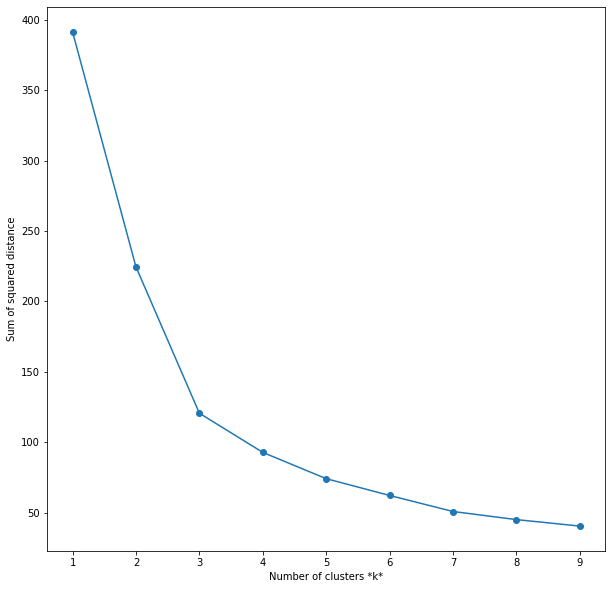

In [1060]:
X = yyc_community_filtered.values[:,1:]
X = np.nan_to_num(X)

sse = []

clusterNum  = list(range(1, 10))

for k in clusterNum:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(X)
    sse.append(k_means.inertia_)

# Plot sse against k
plt.figure(figsize=(10, 10))
plt.plot(clusterNum, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

#### Even though the Elbow method recommends three clusters, I decided to use four in order to better differentitate between communities 

In [1089]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)
yyc_community["Clus_km"] = labels

[3 0 3 2 0 0 1 0 3 3 0 2 3 2 3 0 0 2 0 0 2 3 2 0 2 3 2 0 0 0 2 2 0 2 0 2 0
 0 0 2 2 3 0 0 0 2 3 2 2 0 3 2 2 2 0 2 3 3 0 0 2 3 0 3 3 2 0 0 0 0 0 0 0 0
 3 3 0 0 0 0 3 0 3 0 3 3 2 0 2 0 3 0 0 0 0 2 3 0 0 0 2 0 0 1 0 0 3 0 0 0 2
 3 2 3 0 3 2 3 0 2 0 0 3 2 0 0 0 3 0 0 2 2 2 2 0 0 2 3 0 0 0 0 0 3 2 0 3 2
 0 3 2 3 3 0 0 0 3 1 1 2 0 2 3 3 0 0 0]


In [1090]:
yyc_community["Clus_km"] = labels

In [1092]:
yyc_community.groupby('Clus_km').mean()

RES_CNT_THOUSANDS_PER_SQ_KM  MALE_0_4  MALE_5_14  MALE_15_19  \
Clus_km                                                                 
0                           2.722206  0.058098   0.122688    0.052523   
1                           9.251569  0.023786   0.022474    0.010375   
2                           4.107248  0.064750   0.127322    0.050813   
3                           1.626422  0.053354   0.119206    0.054457   

         MALE_20_24  MALE_25_34  MALE_35_44  MALE_45_54  MALE_55_64  \
Clus_km                                                               
0          0.061114    0.146444    0.158852    0.135421    0.135002   
1          0.064490    0.376385    0.233004    0.107636    0.081494   
2          0.057872    0.173887    0.187272    0.136363    0.108891   
3          0.055260    0.118116    0.144355    0.139578    0.148259   

         MALE_65_74  ...  FEM_55_64  FEM_65_74    FEM_75  ASSESSED_VALUE  \
Clus_km              ...                                                   
0          0.082987  ...   0.137680   0.088061  0.061724        0.623439   
1          0.054669  ...   0.070407   0.052230  0.039705        0.329398   
2          0.061831  ...   0.109791   0.067972  0.041562        0.380450   
3          0.104378  ...   0.150286   0.107734  0.075319        0.700592   

          LONGITUDE   LATITUDE  OWNSHIP_RATIO  SING_FAMILY_RATIO  \
Clus_km                                                            
0       -114.094766  51.038685       0.662496           0.613174   
1       -114.077239  51.034789       0.229917           0.045762   
2       -114.034529  51.044828       0.561534           0.490928   
3       -114.108133  51.019585       0.732554           0.717585   

         PRSCH_CHLD_RATIO  MEDIAN_INCOME_HUNDRED_THOUSAND  
Clus_km                                                    
0                0.066870                        0.669410  
1                0.020671                        0.347463  
2                0.079689                        0.589976  
3                0.053326                        0.842413  

[4 rows x 28 columns]

### Visualization results for clustering

In [1072]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [1073]:
# create map
map_clusters = folium.Map(location=[51.0447, -114.0719], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(yyc_community['LATITUDE'], yyc_community['LONGITUDE'], yyc_community['NAME'], yyc_community['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [1080]:
from folium import plugins

yyc_clusters = folium.Map(location=[51.0447, -114.0719], zoom_start=11)


yyc_geo = r'Community_Boundaries.geojson' # geojson file

# generate choropleth map using the clusters from yyc_community

choropleth = folium.Choropleth(
    geo_data=yyc_geo,
    data=yyc_community,
    columns=['NAME', 'Clus_km'],
    key_on='feature.properties.name',
    fill_color='YlGnBu', 
    fill_opacity=0.9, 
    line_opacity=0.2,
    legend_name='Community Clusters in Calgary'
    
).add_to(yyc_clusters)

style_function = "font-size: 10px; font-weight:bold"

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'], style=style_function, labels=False))
# display map
yyc_clusters

### Foursquare API

#### This function searches through all neighbourhoods in Calgary and get the nearby venues 

In [1343]:
CLIENT_ID = 'DELETED' # your Foursquare ID
CLIENT_SECRET = 'DELETED' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DELETED
CLIENT_SECRET:DELETED


#### getNearbyVenues would take in all neighborhoods names with longitude and latitude and return the nearby venues with 500 m of that longitude and latitude

In [1246]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue id',         
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [1162]:
calgary_venues = getNearbyVenues(names = yyc_community['NAME'],
                                   latitudes= yyc_community['LATITUDE'],
                                   longitudes= yyc_community['LONGITUDE'])

LEGACY
HIGHLAND PARK
MONTGOMERY
TEMPLE
WOODBINE
UNIVERSITY HEIGHTS
BANKVIEW
KELVIN GROVE
SHAGANAPPI
WILDWOOD
ELBOYA
BRIDLEWOOD
LAKE BONAVISTA
SUNALTA
BOWNESS
ASPEN WOODS
RICHMOND
SOMERSET
THORNCLIFFE
COUGAR RIDGE
WHITEHORN
WOODLANDS
MARLBOROUGH PARK
SHAWNESSY
AUBURN BAY
INGLEWOOD
ABBEYDALE
EDGEMONT
ARBOUR LAKE
MIDNAPORE
PALLISER
SPRUCE CLIFF
BRIDGELAND/RIVERSIDE
KILLARNEY/GLENGARRY
HAWKWOOD
CRESCENT HEIGHTS
ROCKY RIDGE
HUNTINGTON HILLS
SHERWOOD
FALCONRIDGE
SUNNYSIDE
MAPLE RIDGE
ROSEMONT
STRATHCONA PARK
SOUTHWOOD
SKYVIEW RANCH
BRITANNIA
CASTLERIDGE
CITADEL
DOVER
SCARBORO
ROSSCARROCK
SADDLE RIDGE
ERIN WOODS
CEDARBRAE
EAU CLAIRE
ELBOW PARK
VARSITY
RAMSAY
RENFREW
MARLBOROUGH
CRESTMONT
ROSEDALE
SILVERADO
VALLEY RIDGE
GLENBROOK
NORTH HAVEN
WALDEN
HILLHURST
RANCHLANDS
TUSCANY
CANYON MEADOWS
SIGNAL HILL
DEER RUN
HAMPTONS
COUNTRY HILLS
BRENTWOOD
ALTADORE
FAIRVIEW
COPPERFIELD
UPPER MOUNT ROYAL
MOUNT PLEASANT
PARKLAND
PARKDALE
SHAWNEE SLOPES
NORTH GLENMORE PARK
PINERIDGE
ACADIA
GREENVIEW
CHAPARRA

In [1163]:
print(calgary_venues.shape)

(886, 8)


In [1164]:
calgary_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         LEGACY              50.857617             -114.005999   
1  HIGHLAND PARK              51.088023             -114.062067   
2  HIGHLAND PARK              51.088023             -114.062067   
3  HIGHLAND PARK              51.088023             -114.062067   
4  HIGHLAND PARK              51.088023             -114.062067   

                   Venue id                    Venue  Venue Latitude  \
0  5e543636494b99000809f0df     Shane Homes - Legacy       50.858113   
1  5a5651eb772fbc3325b7a114              Dairy Queen       51.088919   
2  4bc90447fb84c9b67e561a3e  Highland Park Community       51.087874   
3  57d458b8498e8c8853bf3a6b        Excellent Roofing       51.086872   
4  548788c7498e02e79cb6a5c1                   Cansel       51.088712   

   Venue Longitude              Venue Category  
0      -114.001418          Real Estate Office  
1      -114.063533              Ice Cream Shop  
2      -114.064676                  Playground  
3      -114.058921  Construction & Landscaping  
4      -114.058299            Business Service

In [1125]:
calgary_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
ABBEYDALE                                      4                       4   
ACADIA                                         2                       2   
ALTADORE                                       3                       3   
APPLEWOOD PARK                                 5                       5   
ARBOUR LAKE                                    3                       3   
...                                          ...                     ...   
WILLOW PARK                                    2                       2   
WINDSOR PARK                                   3                       3   
WINSTON HEIGHTS/MOUNTVIEW                      4                       4   
WOODBINE                                       4                       4   
WOODLANDS                                      5                       5   

                           Venue  Venue Latitude  Venue Longitude  \
Neighborhood                                                        
ABBEYDALE                      4               4                4   
ACADIA                         2               2                2   
ALTADORE                       3               3                3   
APPLEWOOD PARK                 5               5                5   
ARBOUR LAKE                    3               3                3   
...                          ...             ...              ...   
WILLOW PARK                    2               2                2   
WINDSOR PARK                   3               3                3   
WINSTON HEIGHTS/MOUNTVIEW      4               4                4   
WOODBINE                       4               4                4   
WOODLANDS                      5               5                5   

                           Venue Category  
Neighborhood                               
ABBEYDALE                               4  
ACADIA                                  2  
ALTADORE                                3  
APPLEWOOD PARK                          5  
ARBOUR LAKE                             3  
...                                   ...  
WILLOW PARK                             2  
WINDSOR PARK                            3  
WINSTON HEIGHTS/MOUNTVIEW               4  
WOODBINE                                4  
WOODLANDS                               5  

[159 rows x 6 columns]

In [1165]:
# one hot encoding
calgary_onehot = pd.get_dummies(calgary_venues['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
calgary_onehot['Neighborhoods'] = calgary_venues['Neighborhood'] 
calgary_onehot['Venue id'] = calgary_venues['Venue id']

# move neighborhood column to the first column
fixed_columns = [calgary_onehot.columns[-1]] + list(calgary_onehot.columns[:-1])
calgary_onehot = calgary_onehot[fixed_columns]

calgary_onehot.loc[calgary_onehot['Neighborhoods'] == 'LOWER MOUNT ROYAL']

Venue id  Accessories Store  Adult Boutique  \
473  4b0586eff964a520ca7622e3                  0               0   
474  5781c2c5498e99a1c2c6daf5                  0               0   
475  4b231a12f964a5204c5324e3                  0               0   
476  4ca8c27844a8224b26c81a40                  0               0   
477  4b05ad3ff964a520d2e022e3                  0               0   
478  57c8e650498e17c4530d406e                  0               0   
479  524b569d498e90f3f39dbc5d                  0               0   
480  4b299480f964a52039a124e3                  0               0   
481  4b0586ebf964a520697522e3                  0               0   
482  4b0586eef964a520397622e3                  0               0   
483  4ccc82e2ee23a14359a71fa8                  0               0   
484  4fc83ca6e4b000e38ec6eadb                  0               0   
485  525b0600498e02747f040cea                  0               0   
486  535a8852498e8d3c52333df1                  0               0   
487  4ffb523ce4b099c7684f2bc8                  0               0   
488  4b0586eff964a520cd7622e3                  0               0   
489  5847879ca598b379e6aed98a                  0               0   
490  4b0b41edf964a5208b2f23e3                  0               0   
491  4c23f0f1a852c928aa5ce26c                  0               0   
492  4b0586eff964a520aa7622e3                  0               0   
493  4b2d4354f964a52097d224e3                  0               0   
494  566766a238faf752983ee20f                  0               0   
495  4b42446af964a5205fd025e3                  0               0   
496  51663012e4b0f303f2ae7d48                  0               0   
497  4c689ece428a0f47dd8d001b                  0               0   
498  4f0dbf2cd5fb971c7442484c                  0               0   
499  4b5113acf964a520224127e3                  0               0   
500  4ba96258f964a5208c233ae3                  0               0   
501  4b4e8479f964a52049f026e3                  0               0   
502  4b0586e7f964a520ef7322e3                  0               0   

     Airport Service  American Restaurant  Art Gallery  Arts & Crafts Store  \
473                0                    0            0                    0   
474                0                    0            0                    0   
475                0                    0            0                    0   
476                0                    0            0                    0   
477                0                    0            0                    0   
478                0                    0            0                    0   
479                0                    0            0                    0   
480                0                    0            0                    0   
481                0                    0            0                    0   
482                0                    0            0                    0   
483                0                    0            0                    0   
484                0                    0            0                    0   
485                0                    0            0                    0   
486                0                    0            0                    0   
487                0                    0            0                    0   
488                0                    0            0                    0   
489                0                    0            0                    0   
490                0                    0            0                    0   
491                0                    0            0                    0   
492                0                    0            0                    0   
493                0                    0            0                    0   
494                0                    0            0                    0   
495                0                    0            0                    0   
496             

In [1166]:
calgary_onehot.shape

(886, 187)

#### Now the same steps but for cluster 3 communities 

In [1280]:
yyc_community_cluster3 = yyc_community.loc[(yyc_community["Clus_km"] == 3)]
yyc_community_cluster3= yyc_community_cluster3.rename(columns = {'NAME':'Neighborhoods'})
yyc_community_cluster3.shape

(40, 30)

In [1281]:
calgary_onehot_cluster3 = pd.merge(calgary_onehot, yyc_community_cluster3[['Neighborhoods']], on = 'Neighborhoods')

In [1282]:
calgary_onehot_cluster3.shape

(167, 187)

#### get_rating function calls Foursquare API and returns the ratings for each Venue id

In [1283]:
def get_rating(names, venue_ids):
    rating_list=[]
    for name, venue_id in zip(names, venue_ids):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
        result = requests.get(url).json()['response']
        try:
            rating_list.append([(
                name,
                venue_id,
                result['venue']['name'],
                result['venue']['rating']
            )]) 
            
        except:
            rating_list.append([(
                name,
                venue_id,
                result['venue']['name'],
                'Not Available'
            )]) 
    venues_ratings = pd.DataFrame([item for rating_list in rating_list for item in rating_list])
    venues_ratings.columns = ['Neighborhood',           
                  'Venue id', 
                  'Venue Name', 
                  'Venue Rating']
    return(venues_ratings)


In [1284]:
cluster3_venues_ratings = get_rating(calgary_onehot_cluster3['Neighborhoods'],
                                     calgary_onehot_cluster3['Venue id'])

LEGACY
MONTGOMERY
MONTGOMERY
MONTGOMERY
MONTGOMERY
MONTGOMERY
MONTGOMERY
MONTGOMERY
MONTGOMERY
MONTGOMERY
MONTGOMERY
MONTGOMERY
MONTGOMERY
MONTGOMERY
SHAGANAPPI
SHAGANAPPI
WILDWOOD
WILDWOOD
WILDWOOD
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
LAKE BONAVISTA
BOWNESS
BOWNESS
BOWNESS
WOODLANDS
WOODLANDS
WOODLANDS
WOODLANDS
INGLEWOOD
INGLEWOOD
INGLEWOOD
INGLEWOOD
INGLEWOOD
INGLEWOOD
BRITANNIA
BRITANNIA
BRITANNIA
BRITANNIA
BRITANNIA
BRITANNIA
BRITANNIA
BRITANNIA
SCARBORO
SCARBORO
SCARBORO
SCARBORO
SCARBORO
SCARBORO
ELBOW PARK
ELBOW PARK
ELBOW PARK
VARSITY
CRESTMONT
CRESTMONT
SILVERADO
VALLEY RIDGE
VALLEY RIDGE
VALLEY RIDGE
VALLEY RIDGE
HAMPTONS
HAMPTONS
COUNTRY HILLS
UPPER MOUNT ROYAL
UPPER MOUNT ROYAL
PARKLAND
PARKLAND
SHAWNEE SLOPES
SHAWNEE SLOPES
SHAWNEE SLOPES
NORTH GLENMORE PARK
NORTH GLENMORE PARK
NORTH GLENMORE PARK
WINS

#### I chose Montgomery community for content based recommender system but we can choose nay other neighborhood in Cluster 3 and perform the analysis. 

In [1285]:
cluster3_available_ratings = cluster3_venues_ratings.loc[cluster3_venues_ratings['Venue Rating'] != 'Not Available']
cluster3_available_ratings = pd.merge(cluster3_available_ratings,calgary_venues[['Venue Category','Venue id']], on = 'Venue id')
cluster3_available_ratings.head()

Neighborhood                  Venue id               Venue Name  \
0   MONTGOMERY  4c62047ceb82d13a969604d6                  NOtaBLE   
1   MONTGOMERY  4bb3ec87737d76b061e83a7c  Shouldice Athletic Park   
2   MONTGOMERY  55351231498ee5b605d43cb9              Tim Hortons   
3   MONTGOMERY  4d2624b8d2668cfa2a14c5db                   Subway   
4   MONTGOMERY  4dcb5515c65bccd86744de6d                Pizza Hut   

  Venue Rating  Venue Category  
0          8.3      Restaurant  
1            8            Park  
2          6.3     Coffee Shop  
3          6.2  Sandwich Place  
4          6.3     Pizza Place

In [1286]:
cluster3_available_onehot = pd.merge(cluster3_available_ratings, calgary_onehot, on = 'Venue id')
cluster3_available_onehot

Neighborhood_x                  Venue id               Venue Name  \
0      MONTGOMERY  4c62047ceb82d13a969604d6                  NOtaBLE   
1      MONTGOMERY  4bb3ec87737d76b061e83a7c  Shouldice Athletic Park   
2      MONTGOMERY  55351231498ee5b605d43cb9              Tim Hortons   
3      MONTGOMERY  4d2624b8d2668cfa2a14c5db                   Subway   
4      MONTGOMERY  4dcb5515c65bccd86744de6d                Pizza Hut   
..            ...                       ...                      ...   
92      PATTERSON  4c896b709ef0224b840c527b                    Shell   
93      PATTERSON  4c896b709ef0224b840c527b                    Shell   
94    CHARLESWOOD  4b67279df964a520373e2be3             London Drugs   
95        BAYVIEW  4b0586e9f964a520cb7422e3      South Glenmore Park   
96        BAYVIEW  4bc930f03740b71375705e65             Petro-Canada   

   Venue Rating  Venue Category  Accessories Store  Adult Boutique  \
0           8.3      Restaurant                  0               0   
1             8            Park                  0               0   
2           6.3     Coffee Shop                  0               0   
3           6.2  Sandwich Place                  0               0   
4           6.3     Pizza Place                  0               0   
..          ...             ...                ...             ...   
92          6.2     Gas Station                  0               0   
93          6.2     Gas Station                  0               0   
94          5.6        Pharmacy                  0               0   
95          9.3            Park                  0               0   
96          6.3     Gas Station                  0               0   

    Airport Service  American Restaurant  Art Gallery  ...  Train  \
0                 0                    0            0  ...      0   
1                 0                    0            0  ...      0   
2                 0                    0            0  ...      0   
3                 0                    0            0  ...      0   
4                 0                    0            0  ...      0   
..              ...                  ...          ...  ...    ...   
92                0                    0            0  ...      0   
93                0                    0            0  ...      0   
94                0                    0            0  ...      0   
95                0                    0            0  ...      0   
96                0                    0            0  ...      0   

    Travel & Transport  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0                    0                              0                      0   
1                    0                              0                      0   
2                    0                              0                      0   
3                    0                              0                      0   
4                    0                              0                      0   
..                 ...                            ...                    ...   
92                   0                              0                      0   
93                   0                              0                      0   
94                   0                              0                      0   
95                   0                              0                      0   
96                   0                              0                      0   

    Waterfall  Wine Bar  Wings Joint  Women's Store  Yoga Studio  \
0           0         0            0              0            0   
1           0         0            0              0            0   
2           0         0            0              0            0   
3           0         0            0              0            0   
4           0         0            0              0            0   
..        ...       ...          ...            ...          ...   
92          0         0        

### Collaborative recommender system

#### Assuming we want to recommend a venue for Wildwood community

In [1287]:
wildwood_venues = cluster3_available_ratings.loc[cluster3_available_ratings['Neighborhood'] == 'WILDWOOD']
wildwood_venues

Neighborhood                  Venue id         Venue Name Venue Rating  \
8     WILDWOOD  4bba279598c7ef3be3c43202      Edworthy Park          9.3   
9     WILDWOOD  4b3ffecbf964a520e2b325e3  Edworthy Dog Park          7.5   

  Venue Category  
8           Park  
9        Dog Run

In [1288]:
#Filtering out communities that have the venue categories of Wildwood community 
wildwoodSubset = cluster3_available_ratings[cluster3_available_ratings['Venue Category'].isin(wildwood_venues['Venue Category'].tolist())]
wildwoodSubset.head()

Neighborhood                  Venue id               Venue Name  \
1    MONTGOMERY  4bb3ec87737d76b061e83a7c  Shouldice Athletic Park   
8      WILDWOOD  4bba279598c7ef3be3c43202            Edworthy Park   
9      WILDWOOD  4b3ffecbf964a520e2b325e3        Edworthy Dog Park   
83      BAYVIEW  4b0586e9f964a520cb7422e3      South Glenmore Park   

   Venue Rating Venue Category  
1             8           Park  
8           9.3           Park  
9           7.5        Dog Run  
83          9.3           Park

#### Unfortunately Collaborative recommender system does not work since there is not enough data to run the algorithm. 

### Content based recommender system

In [1289]:
montgomery_venues = cluster3_available_ratings.loc[cluster3_available_ratings['Neighborhood'] == 'MONTGOMERY']
montgomery_venues

Neighborhood                  Venue id               Venue Name  \
0   MONTGOMERY  4c62047ceb82d13a969604d6                  NOtaBLE   
1   MONTGOMERY  4bb3ec87737d76b061e83a7c  Shouldice Athletic Park   
2   MONTGOMERY  55351231498ee5b605d43cb9              Tim Hortons   
3   MONTGOMERY  4d2624b8d2668cfa2a14c5db                   Subway   
4   MONTGOMERY  4dcb5515c65bccd86744de6d                Pizza Hut   
5   MONTGOMERY  4dae25c55da3cca6f0a39f60                      KFC   
6   MONTGOMERY  4bf4a947370e76b04796bd4a                 7-Eleven   

  Venue Rating        Venue Category  
0          8.3            Restaurant  
1            8                  Park  
2          6.3           Coffee Shop  
3          6.2        Sandwich Place  
4          6.3           Pizza Place  
5          6.2  Fast Food Restaurant  
6            6     Convenience Store

In [1296]:
montgomery_venue_profile = cluster3_available_onehot.loc[cluster3_available_onehot['Neighborhoods'] == 'MONTGOMERY']
montgomery_venue_profile.drop(columns = ['Neighborhood_x', 'Venue Rating', 'Venue id', 'Venue Name', 'Venue Category', 'Neighborhoods'], inplace = True)
montgomery_venue_profile

C:\Users\Siavash Fard\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Accessories Store  Adult Boutique  Airport Service  American Restaurant  \
0                  0               0                0                    0   
1                  0               0                0                    0   
2                  0               0                0                    0   
3                  0               0                0                    0   
4                  0               0                0                    0   
5                  0               0                0                    0   
6                  0               0                0                    0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   0   
1            0                    0                 0                   0   
2            0                    0                 0                   0   
3            0                    0                 0                   0   
4            0                    0                 0                   0   
5            0                    0                 0                   0   
6            0                    0                 0                   0   

   BBQ Joint  Bakery  ...  Trail  Train  Travel & Transport  \
0          0       0  ...      0      0                   0   
1          0       0  ...      0      0                   0   
2          0       0  ...      0      0                   0   
3          0       0  ...      0      0                   0   
4          0       0  ...      0      0                   0   
5          0       0  ...      0      0                   0   
6          0       0  ...      0      0                   0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Waterfall  Wine Bar  \
0                              0                      0          0         0   
1                              0                      0          0         0   
2                              0                      0          0         0   
3                              0                      0          0         0   
4                              0                      0          0         0   
5                              0                      0          0         0   
6                              0                      0          0         0   

   Wings Joint  Women's Store  Yoga Studio  
0            0              0            0  
1            0              0            0  
2            0              0            0  
3            0              0            0  
4            0              0            0  
5            0              0            0  
6            0              0            0  

[7 rows x 185 columns]

#### Calculating weighted average for Montgomery

In [1297]:
montgomery_venues['Venue Rating']

0    8.3
1      8
2    6.3
3    6.2
4    6.3
5    6.2
6      6
Name: Venue Rating, dtype: object

In [1298]:
montgomeryProfile = montgomery_venue_profile.transpose().dot(montgomery_venues['Venue Rating'])
montgomeryProfile

Accessories Store      0
Adult Boutique         0
Airport Service        0
American Restaurant    0
Art Gallery            0
                      ..
Waterfall              0
Wine Bar               0
Wings Joint            0
Women's Store          0
Yoga Studio            0
Length: 185, dtype: object

#### Now we group the cluster 3 by communities and average their based on their venue category

In [1316]:
cluster3_onehot_grouped = cluster3_available_onehot.groupby('Neighborhoods').mean().reset_index()
cluster3_onehot_grouped.drop(cluster3_onehot_grouped.index[11], axis = 0, inplace = True)
cluster3_onehot_grouped = cluster3_onehot_grouped.set_index(['Neighborhoods']) 
cluster3_onehot_grouped.shape

(21, 185)

In [1318]:
similar_communities_df = ((cluster3_onehot_grouped*montgomeryProfile).sum(axis=1))/(montgomeryProfile.sum())
similar_communities_df.head()

Neighborhoods
BAYVIEW        0.084567
BOWNESS        0.000000
BRITANNIA      0.053277
CHARLESWOOD    0.000000
COACH HILL     0.031712
dtype: float64

In [1320]:
similar_communities_df = similar_communities_df.sort_values(ascending = False)
similar_communities_df

Neighborhoods
BAYVIEW                      0.084567
WILDWOOD                     0.084567
BRITANNIA                    0.053277
LAKE BONAVISTA               0.043793
EAGLE RIDGE                  0.043693
COLLINGWOOD                  0.042283
PATTERSON                    0.031712
COACH HILL                   0.031712
MEADOWLARK PARK              0.029457
PARKLAND                     0.000000
WINSTON HEIGHTS/MOUNTVIEW    0.000000
SCARBORO                     0.000000
INGLEWOOD                    0.000000
SHAGANAPPI                   0.000000
COUNTRY HILLS                0.000000
SUNALTA                      0.000000
UPPER MOUNT ROYAL            0.000000
CHARLESWOOD                  0.000000
VALLEY RIDGE                 0.000000
BOWNESS                      0.000000
WOODLANDS                    0.000000
dtype: float64

In [1322]:
cluster3_available_ratings.loc[cluster3_available_ratings['Neighborhood'].isin(similar_communities_df.head().keys())]

Neighborhood                  Venue id  \
8         WILDWOOD  4bba279598c7ef3be3c43202   
9         WILDWOOD  4b3ffecbf964a520e2b325e3   
10  LAKE BONAVISTA  5325e880498eb79a55daadb7   
11  LAKE BONAVISTA  4b7a26c3f964a520b0242fe3   
12  LAKE BONAVISTA  4d6d1a14cf7e41bd2cad8285   
13  LAKE BONAVISTA  4ba3cba4f964a520406038e3   
14  LAKE BONAVISTA  4c9bdfe90e9bb1f7e7c3ce5f   
15  LAKE BONAVISTA  4bd4f1d429eb9c7460b592e1   
16  LAKE BONAVISTA  4b5b257af964a5206ce628e3   
24       BRITANNIA  54457979498e5391918f06c4   
25       BRITANNIA  5a679a8a59c42311fd6bec88   
26       BRITANNIA  4b771183f964a520007a2ee3   
27       BRITANNIA  4ba12ae3f964a520419e37e3   
28       BRITANNIA  4c08f9a6a1b32d7fbdcd96f0   
68     EAGLE RIDGE  4b0586e9f964a520c17422e3   
69     EAGLE RIDGE  4ba50faef964a5206cd738e3   
70     EAGLE RIDGE  4e8673f7d66a9b178e910fed   
83         BAYVIEW  4b0586e9f964a520cb7422e3   
84         BAYVIEW  4bc930f03740b71375705e65   

                          Venue Name Venue Rating     Venue Category  
8                      Edworthy Park          9.3               Park  
9                  Edworthy Dog Park          7.5            Dog Run  
10                    The Lake House          7.4         Restaurant  
11          Brewsters Lake Bonavista          7.1            Brewery  
12                   TD Canada Trust          6.5               Bank  
13                            Subway          6.4     Sandwich Place  
14                Shoppers Drug Mart          6.2           Pharmacy  
15  Safeway Bonavista Shopping Plaza          6.1      Grocery Store  
16          Lake Bonavista Promenade          5.6      Shopping Mall  
24                 Village Ice Cream          8.5     Ice Cream Shop  
25                   Monogram Coffee          8.3        Coffee Shop  
26                   Sunterra Market            8  Food & Drink Shop  
27                         Starbucks          7.1        Coffee Shop  
28                    RBC Royal Bank          6.5               Bank  
68  Heritage Park Historical Village          8.5     History Museum  
69                     Railroad Cafe          6.8     Sandwich Place  
70                      Petro-Canada          6.2        Gas Station  
83               South Glenmore Park          9.3               Park  
84                      Petro-Canada          6.3        Gas Station

In [1206]:
calgary_grouped = calgary_onehot.groupby('Neighborhoods').mean().reset_index()
calgary_grouped.head()

Neighborhoods  Accessories Store  Adult Boutique  Airport Service  \
0       ABBEYDALE                0.0             0.0              0.0   
1          ACADIA                0.0             0.0              0.0   
2        ALTADORE                0.0             0.0              0.0   
3  APPLEWOOD PARK                0.0             0.0              0.0   
4     ARBOUR LAKE                0.0             0.0              0.0   

   American Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0                  0.0          0.0                  0.0               0.0   
1                  0.0          0.0                  0.0               0.0   
2                  0.0          0.0                  0.0               0.0   
3                  0.0          0.0                  0.0               0.0   
4                  0.0          0.0                  0.0               0.0   

   Athletics & Sports  BBQ Joint  ...  Trail  Train  Travel & Transport  \
0                 0.0        0.0  ...   0.00    0.0                 0.0   
1                 0.0        0.0  ...   0.00    0.0                 0.0   
2                 0.0        0.0  ...   0.00    0.0                 0.0   
3                 0.0        0.0  ...   0.25    0.0                 0.0   
4                 0.0        0.0  ...   0.00    0.0                 0.0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Waterfall  Wine Bar  \
0                            0.0                    0.0        0.0       0.0   
1                            0.0                    0.0        0.0       0.0   
2                            0.0                    0.0        0.0       0.0   
3                            0.0                    0.0        0.0       0.0   
4                            0.0                    0.0        0.0       0.0   

   Wings Joint  Women's Store  Yoga Studio  
0          0.2            0.0          0.0  
1          0.0            0.0          0.0  
2          0.0            0.0          0.0  
3          0.0            0.0          0.0  
4          0.0            0.0          0.0  

[5 rows x 186 columns]

### Sorting the top three venues in Calgary

In [750]:
num_top_venues = 3

for hood in calgary_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = calgary_grouped[calgary_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

----ABBEYDALE----
                     venue  freq
0              Wings Joint  0.25
1  Health & Beauty Service  0.25
2           Sandwich Place  0.25


----ACADIA----
                  venue  freq
0  Gym / Fitness Center   0.5
1                  Pool   0.5
2     Accessories Store   0.0


----ALTADORE----
            venue  freq
0         Dog Run  0.33
1             Pub  0.33
2  Ice Cream Shop  0.33


----APPLEWOOD PARK----
                        venue  freq
0  Construction & Landscaping   0.2
1                        Park   0.2
2                Liquor Store   0.2


----ARBOUR LAKE----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.33
1                                      Lake  0.33
2                             Grocery Store  0.33


----ASPEN WOODS----
                  venue  freq
0             Gift Shop  0.14
1   Japanese Restaurant  0.14
2  Fast Food Restaurant  0.14


----BANFF TRAIL----
                venue  freq
0      Soccer S

2  Arts & Crafts Store  0.25


----INGLEWOOD----
          venue  freq
0   Gas Station  0.33
1         Diner  0.17
2  Liquor Store  0.17


----KELVIN GROVE----
               venue  freq
0  Convenience Store   1.0
1  Accessories Store   0.0
2        Pizza Place   0.0


----KILLARNEY/GLENGARRY----
               venue  freq
0           Pharmacy  0.25
1  Convenience Store  0.25
2             School  0.25


----KINCORA----
               venue  freq
0         Playground   1.0
1  Accessories Store   0.0
2          Piano Bar   0.0


----KINGSLAND----
              venue  freq
0       Pizza Place  0.08
1  Sushi Restaurant  0.08
2       Coffee Shop  0.08


----LAKE BONAVISTA----
          venue  freq
0          Lake  0.07
1          Bank  0.07
2  Hockey Arena  0.07


----LAKEVIEW----
               venue  freq
0                Spa   1.0
1  Accessories Store   0.0
2          Piano Bar   0.0


----LEGACY----
                venue  freq
0  Real Estate Office   1.0
1           Piano Bar   0.0
2  

                     venue  freq
0             Home Service   1.0
1                     Pier   0.0
2  New American Restaurant   0.0


----SKYVIEW RANCH----
              venue  freq
0      Home Service  0.25
1  Business Service  0.25
2       Gas Station  0.25


----SOMERSET----
          venue  freq
0   Bus Station   0.2
1         Plaza   0.2
2  Neighborhood   0.2


----SOUTH CALGARY----
                venue  freq
0  Athletics & Sports  0.25
1      Breakfast Spot  0.25
2      Sandwich Place  0.25


----SOUTHVIEW----
         venue  freq
0  Golf Course   0.5
1  Bus Station   0.5
2    Piano Bar   0.0


----SOUTHWOOD----
           venue  freq
0  Grocery Store  0.25
1    Supermarket  0.25
2   Liquor Store  0.25


----SPRUCE CLIFF----
                 venue  freq
0                 Café  0.25
1                  Gym  0.25
2  Japanese Restaurant  0.25


----STRATHCONA PARK----
               venue  freq
0           Building   0.5
1      Grocery Store   0.5
2  Accessories Store   0.0


----SU

In [758]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = calgary_grouped['Neighborhoods']

for ind in np.arange(calgary_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(calgary_grouped.iloc[ind, :], num_top_venues)

# neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhoods'] == 'BANKVIEW']
neighborhoods_venues_sorted.head()

Neighborhoods                     1st Most Common Venue  \
0       ABBEYDALE                               Wings Joint   
1          ACADIA                                      Pool   
2        ALTADORE                                       Pub   
3  APPLEWOOD PARK                              Liquor Store   
4     ARBOUR LAKE  Residential Building (Apartment / Condo)   

  2nd Most Common Venue 3rd Most Common Venue    4th Most Common Venue  \
0     Convenience Store        Sandwich Place  Health & Beauty Service   
1  Gym / Fitness Center           Yoga Studio              Flower Shop   
2        Ice Cream Shop               Dog Run              Yoga Studio   
3                  Park                 Trail             Home Service   
4                  Lake         Grocery Store              Yoga Studio   

        5th Most Common Venue  
0                 Yoga Studio  
1               Garden Center  
2                 Flower Shop  
3  Construction & Landscaping  
4                 Flower Shop

### Clustering based on venues using K-Means

#### I only did this out of my curiosity to see how the communities are clustered together based on frequency and venue category. 

In [1325]:
# set number of clusters
kclusters = 5

calgary_grouped_clustering = calgary_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(calgary_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 1, 4, 4, 4, 1, 1, 3])

In [1331]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted.rename(columns = {'Neighborhoods':'NAME'}, inplace = True)

calgary_merged = yyc_community

# merge calgary_grouped with yyc_calgary to add latitude/longitude for each neighborhood
calgary_merged = yyc_community.join(neighborhoods_venues_sorted.set_index('NAME'), on='NAME')

calgary_merged.loc[(calgary_merged['Cluster Labels'] == 1.0) & (calgary_merged['Clus_km'] == 3.0)][['NAME','Clus_km','Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']]

NAME  Clus_km  Cluster Labels    1st Most Common Venue  \
2        MONTGOMERY        3             1.0      Japanese Restaurant   
12   LAKE BONAVISTA        3             1.0                     Park   
25        INGLEWOOD        3             1.0              Gas Station   
65     VALLEY RIDGE        3             1.0               Restaurant   
117        GLENDALE        3             1.0       Chinese Restaurant   
152       PATTERSON        3             1.0  Health & Beauty Service   
155     CHARLESWOOD        3             1.0                 Building   
159         BAYVIEW        3             1.0              Gas Station   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
2               Restaurant     Food & Drink Shop                  Park   
12                    Bank          Skating Rink         Shopping Mall   
25                   Diner          Cycle Studio                  Pool   
65        Greek Restaurant     Convenience Store           Yoga Studio   
117            Pizza Place           Yoga Studio           Flower Shop   
152  Vietnamese Restaurant                 Trail           Pizza Place   
155               Pharmacy           Coffee Shop           Gas Station   
159          Grocery Store  Other Great Outdoors                  Park   

    5th Most Common Venue  
2             Coffee Shop  
12                Brewery  
25           Liquor Store  
65            Flower Shop  
117         Garden Center  
152     Convenience Store  
155         Garden Center  
159             Gastropub

### Thanks for your time. I really appreciate any comment or feedback or anything that can help me improve my code or this report in general. 